# TeslaMax Optimization

Teslamax model:

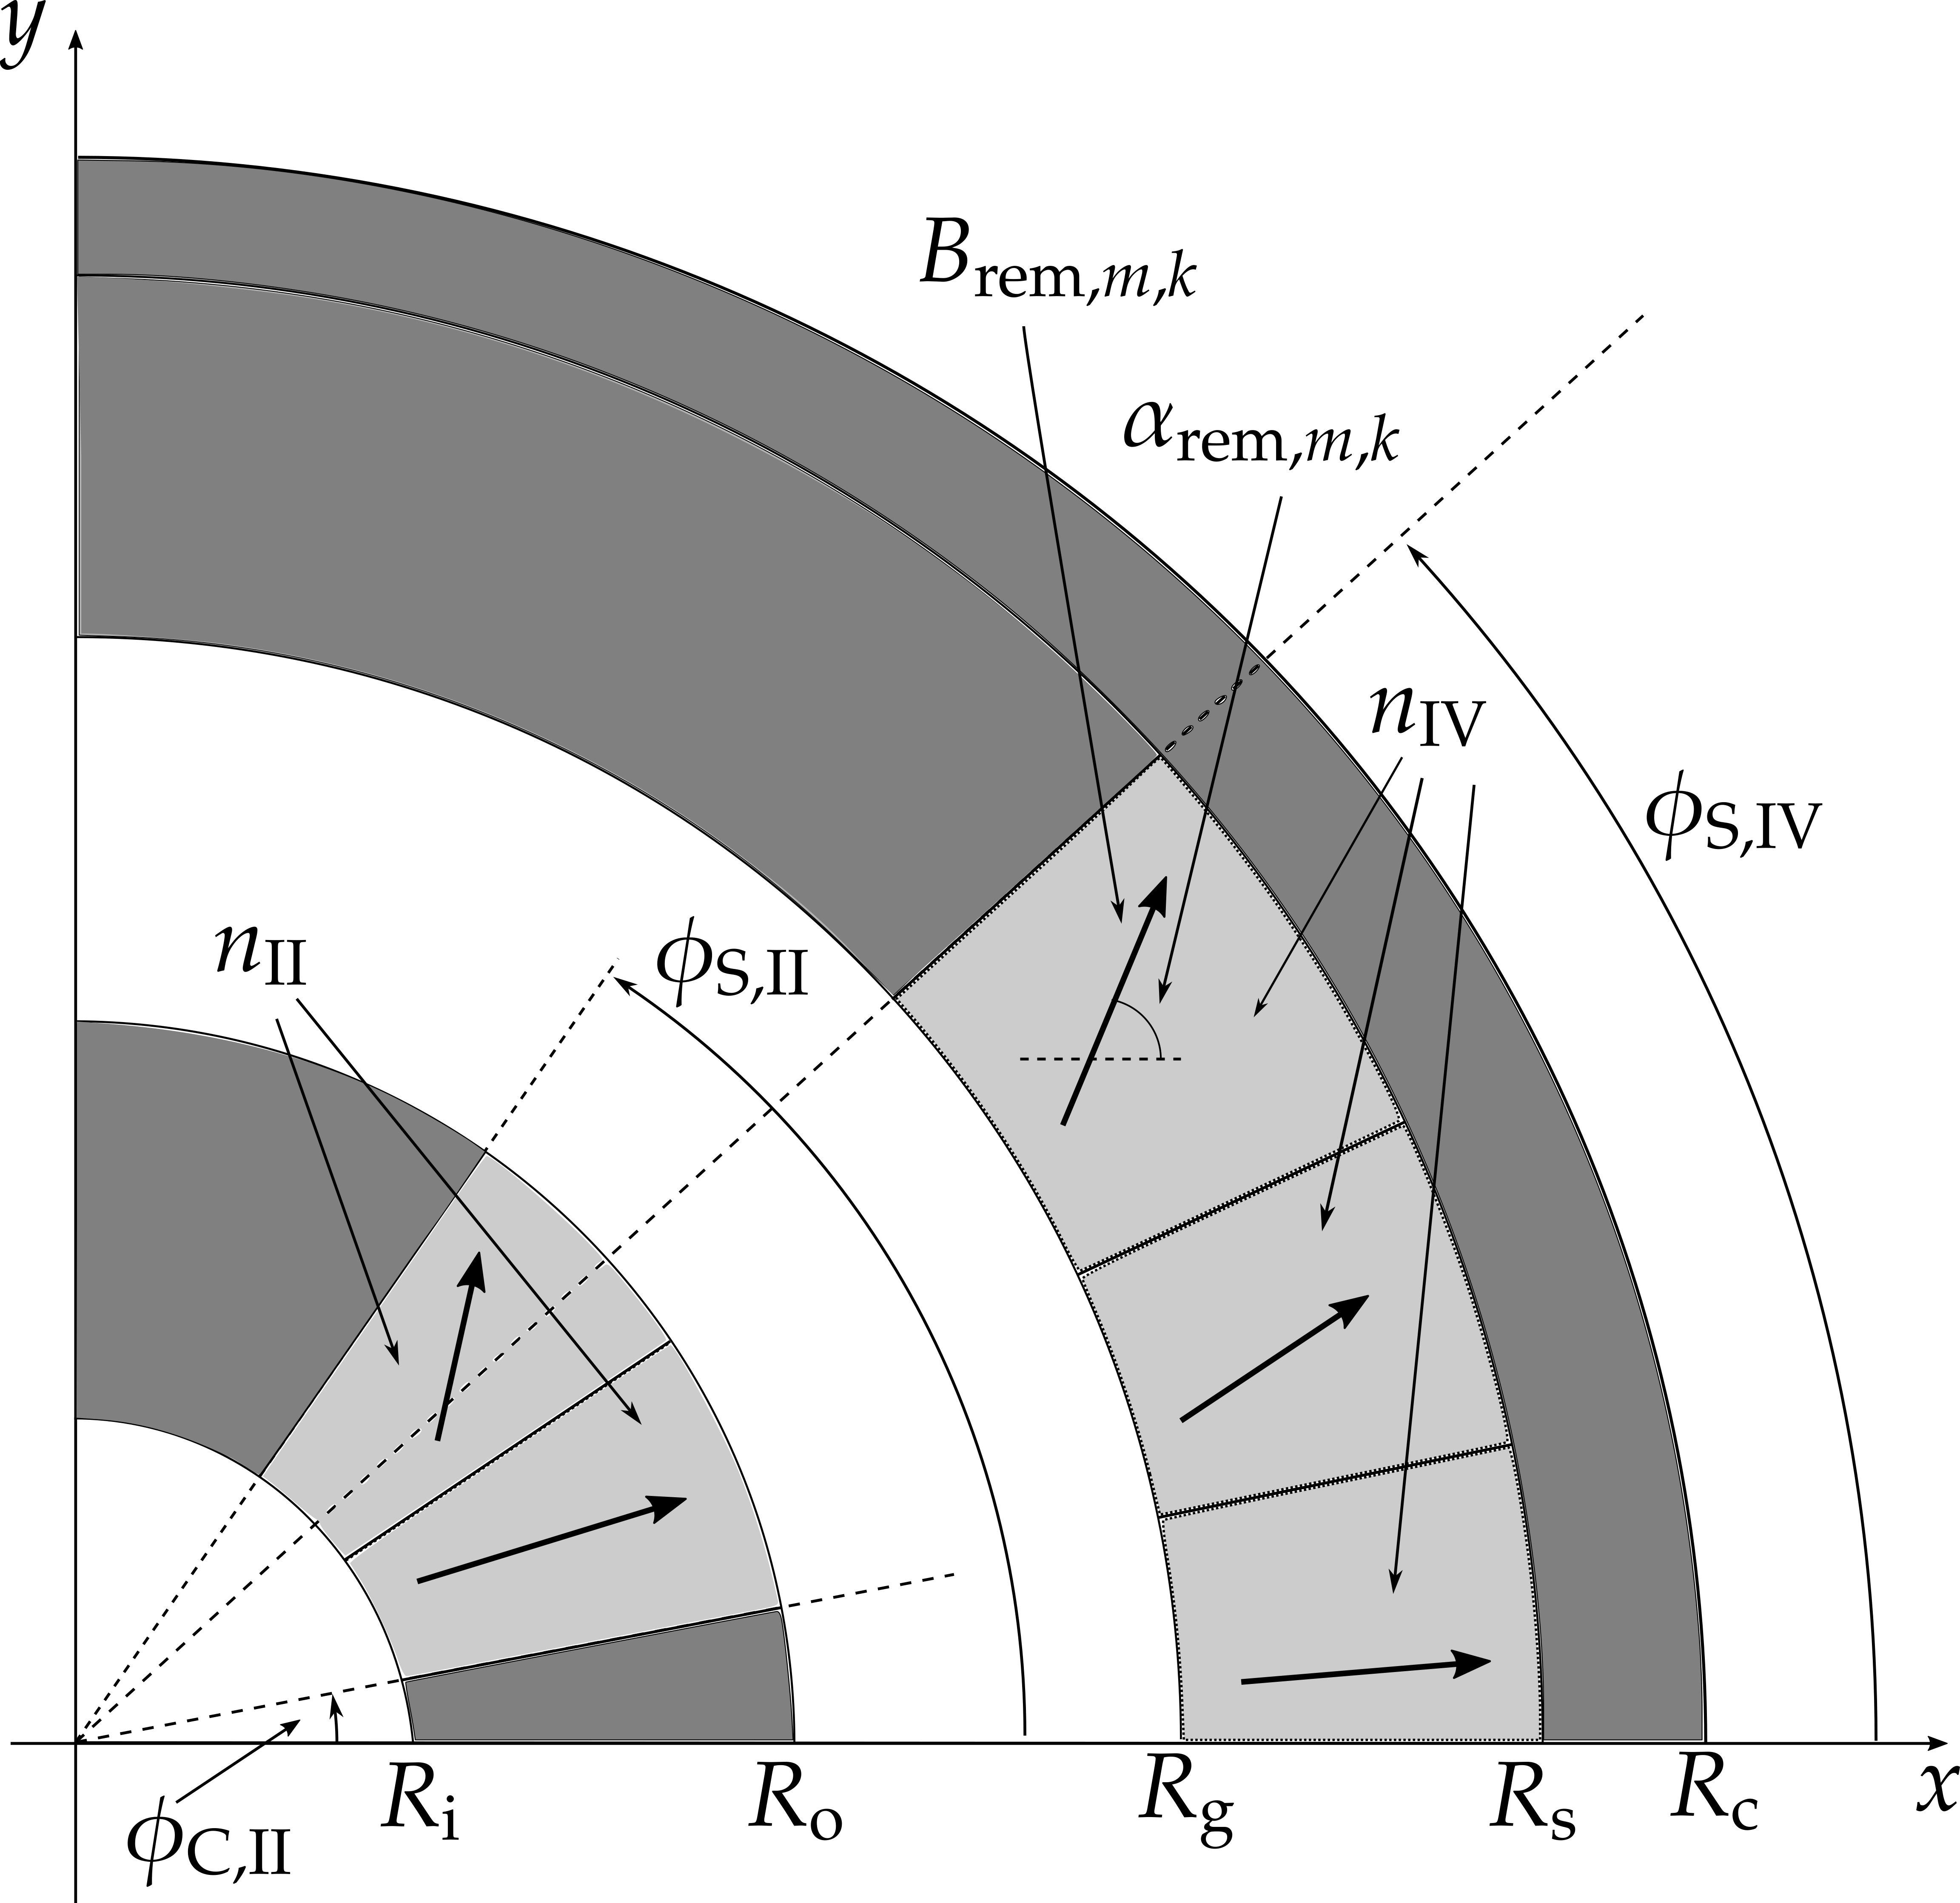

In [118]:
from IPython.display import Image, display, HTML
Image("figures/teslamax.png",width=500)

We are intererested in finding the optimal set of remanence angles $\alpha_{\mathrm{rem},m,k}$ that will maximize some metric in the air gap.

In [119]:
from pathlib import Path
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from pandas import Series, DataFrame
import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel
from scipy.integrate import trapz

In [120]:
B_HIGH_LIMIT = 1.85

TESLAMAX_PATH = Path(".")

PLAYGROUND_DIR = "teslamax-play"

RAMP_RESULTS_DIR_FMT = "ramp_Bh_%d_FM_%d"

In [121]:
os.chdir(TESLAMAX_PATH)

In [122]:
os.getcwd()

'C:\\Users\\Luis Felipe\\Documents\\GitHub\\TeslaMax'

## Objective function

We consider that the magnetic profile is a good representation of what the regenerators experience, and it is what is used as an input to AMR models. Therefore, the optimization procedure that is developed here is denoted *profile matching*: we calculate the optimal remanence angles for each magnet segments, such that the deviation between the resulting profile and a *target* ramp profile is minimized:

$$
\mathcal{K}(\vec{x}) = \frac{1}{2\pi}\left(\int_0^{2\pi}\left( \frac{\overline{B}(\phi,\vec{x}) - \overline{B}_{\mathrm{ramp}} (\phi,B_{\mathrm{min}},B_{\mathrm{max}})}{B_{\mathrm{max}} - B_{\mathrm{min}}} \right)^{2}\mathrm{d}\phi\right)
$$

where $\overline{B}(\phi,\vec{x})$ is the magnetic profile calculated at position $\phi$ when the remanence angles are represented by $\vec{x}$, and $\overline{B}_{\mathrm{ramp}} \left(\phi,B_{\mathrm{min}},B_{\mathrm{max}},F_{\mathrm{M}})\right)$ is the ramp profile at angle $\phi$, between plateaus $B_{\mathrm{min}}$ and $B_{\mathrm{max}}$ for the low and high field regions, with a high field fraction $F_{\mathrm{M}}$ (the fraction of the entire cycle where the field is at the high level).

## Optimization using Scipy

In [123]:
def optimize_ramp(B_high,field_fraction,params):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside "teslamax-play".
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    B_low = 0.0
    
    target_args = (B_high,B_low,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / sdir )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    return (tmm_g,cost_function)
    

In [124]:
import nemplot
from nemplot import nemplot_parameters

In [125]:
nemplot.set_dpi(1500)
nemplot.set_fontsize(22)
nemplot.set_latex_font("Palatino")

In [126]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [127]:
def plot_optimized_ramp(B_high,field_fraction):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations
    and a ramp profile between 0 and 'B_high', with 'field_fraction'. The TeslaMax
    results are read from the appropriate files inside PLAYGROUND_DIR.
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    """
 

    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = TESLAMAX_PATH / PLAYGROUND_DIR / sdir
    
    profile_file = teslamax_playground / teslamax.MAGNETIC_PROFILE_FILENAME
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    
    phi_vector_g, B_vector_g = teslamax.read_comsol_profile_data(str(profile_file))
    
    lw = 2.0
    profile_axes_g.plot(phi_vector_g,B_vector_g,linewidth=lw)
    profile_axes_g.set_xlim(0,np.max(phi_vector_g))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
        
    #profile_axes_g.set_yticks(np.arange(0,B_HIGH_LIMIT+0.2,0.2),minor=True)
    
    B_low = 0.0
    B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_low,field_fraction)
    profile_axes_g.plot(phi_vector_g,B_inst_vector,'--',linewidth=lw)

    nemplot.save_figure(profile_fig_g,"profile_optimized_B_%d_FM_%d" %(B_high*1000,field_fraction*100))
    return (phi_vector_g , B_vector_g)

### Compact magnet

These are the parameters that are being used to study more compact systems:

In [128]:
# Fixed parameters



FIXED_PARAMETERS_MAGNET = {"R_i": 0.030,
                "h_fc": 0.025,
                "R_e": 0.8,
                "n_II": 0,
                "n_IV": 5,
                "phi_C_II": 0,
                "phi_C_IV": 0,
                "phi_S_II" : 0,
                "phi_S_IV": 60,          
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

In [129]:
# variable parameters
#linha 8

params_optimization_2 = FIXED_PARAMETERS_MAGNET.copy()

params_optimization_2["R_g"] = 0.155
params_optimization_2["R_o"] = 0.12


B_rem = 1.26
field_fraction = 0.30

In [130]:
R_g = params_optimization_2["R_g"]
R_o = params_optimization_2["R_o"]
n_II = params_optimization_2["n_II"]
n_IV = params_optimization_2["n_IV"]

n = n_II + n_IV

# expand parameters to include remanence magnitudes for each segment
params_optimization_2 = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      params_optimization_2, 
                                                                      "B_rem")

We test three different values of the high field to study the scale of K:

Parameters:
{'R_i': 0.03, 'h_fc': 0.025, 'R_e': 0.8, 'n_II': 0, 'n_IV': 5, 'phi_C_II': 0, 'phi_C_IV': 0, 'phi_S_II': 0, 'phi_S_IV': 60, 'mu_r_II': 1.05, 'mu_r_IV': 1.05, 'linear_iron': 1, 'mu_r_iron': 5000.0, 'R_g': 0.155, 'R_o': 0.12, 'B_rem_IV_1': 1.26, 'B_rem_IV_2': 1.26, 'B_rem_IV_3': 1.26, 'B_rem_IV_4': 1.26, 'B_rem_IV_5': 1.26, 'R_s': 0.25, 'h_gap': 0.035, 'alpha_rem_IV_1': 6.840971534533734, 'alpha_rem_IV_2': 23.768117248321456, 'alpha_rem_IV_3': 57.86941753838613, 'alpha_rem_IV_4': 105.33468844262461, 'alpha_rem_IV_5': 150.27567316233987}
Value of the objective function:
0.0007358688343473759
W
5002.508184151967
Wall time: 20min 7s


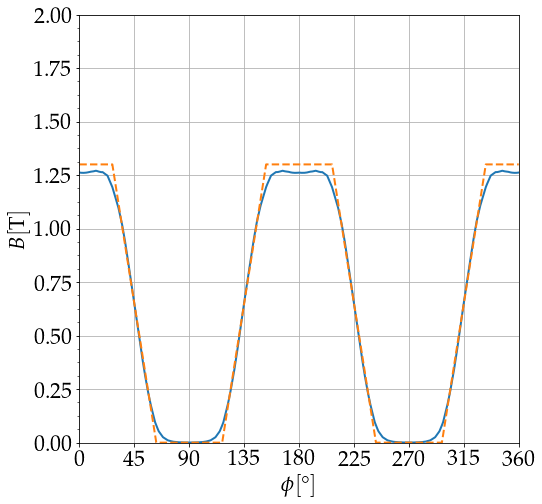

In [138]:
%%time
params_optimization_2["R_s"] = 0.250
B_high = 1.3

tmm_g_2, K_2= optimize_ramp(B_high,field_fraction,params_optimization_2)
print("Parameters:")
print(tmm_g_2.params)
print("Value of the objective function:")
print(K_2)
%matplotlib inline

phi_vector_g, B_vector_g = plot_optimized_ramp(B_high,field_fraction)

phi_vector_g = np.deg2rad(phi_vector_g)
B_vector_g_2 = B_vector_g[0:90]
phi_vector_g_2 = phi_vector_g[0:90]
#calcula a energia total nesta área
W = ((R_g*1000)**2 - (R_o*1000)**2)*0.5*trapz(B_vector_g_2**2,phi_vector_g_2)
print("W")
print(W)

Value of the objective function:
0.0005426618578046257
W
5127.856246322238
Wall time: 22min 27s


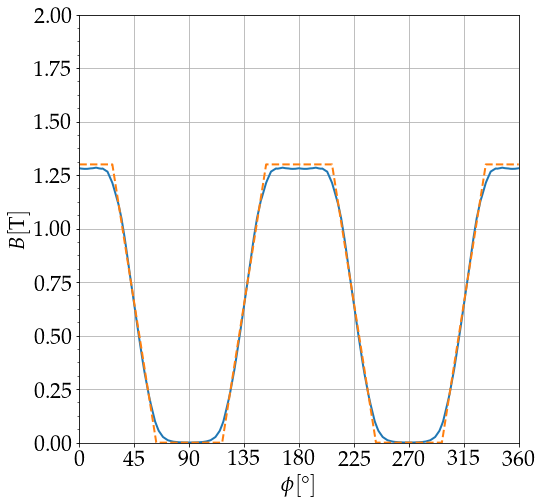

In [143]:
%%time
params_optimization_2["R_s"] = 0.253


tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)
%matplotlib inline

phi_vector_g, B_vector_g = plot_optimized_ramp(B_high,field_fraction)

phi_vector_g = np.deg2rad(phi_vector_g)
B_vector_g_2 = B_vector_g[0:90]
phi_vector_g_2 = phi_vector_g[0:90]
#calcula a energia total nesta área
W = ((R_g*1000)**2 - (R_o*1000)**2)*0.5*trapz(B_vector_g_2**2,phi_vector_g_2)
print("W")
print(W)


Value of the objective function:
0.0004523038560520561
W
5182.412758936593


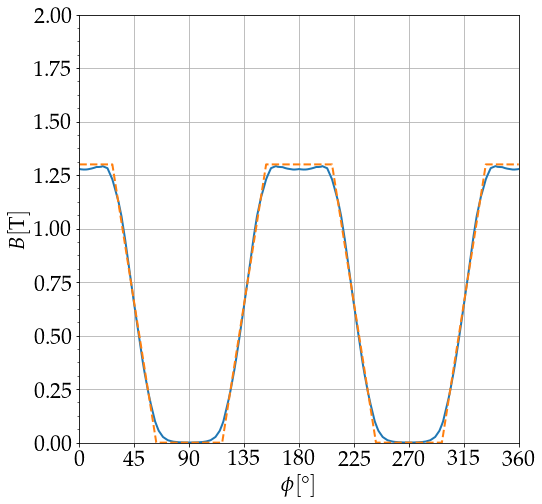

In [142]:

params_optimization_2["R_s"] = 0.2545

tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)
%matplotlib inline

phi_vector_g, B_vector_g = plot_optimized_ramp(B_high,field_fraction)

phi_vector_g = np.deg2rad(phi_vector_g)
B_vector_g_2 = B_vector_g[0:90]
phi_vector_g_2 = phi_vector_g[0:90]
#calcula a energia total nesta área
W = ((R_g*1000)**2 - (R_o*1000)**2)*0.5*trapz(B_vector_g_2**2,phi_vector_g_2)
print("W")
print(W)

Value of the objective function:
0.00048042264407256236
W
5164.900231667531


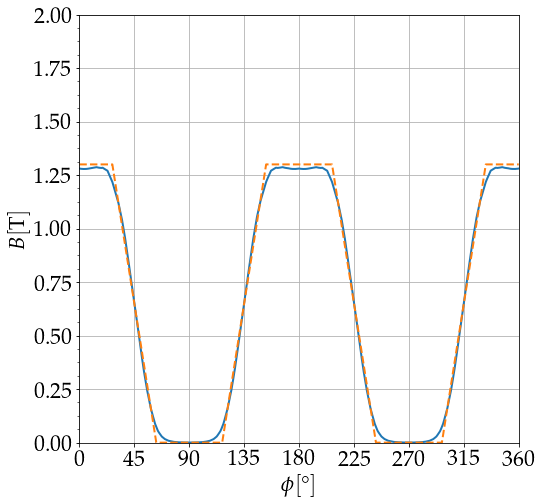

In [139]:



params_optimization_2["R_s"] = 0.2535



tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)
%matplotlib inline

phi_vector_g, B_vector_g = plot_optimized_ramp(B_high,field_fraction)

phi_vector_g = np.deg2rad(phi_vector_g)
B_vector_g_2 = B_vector_g[0:90]
phi_vector_g_2 = phi_vector_g[0:90]
#calcula a energia total nesta área
W = ((R_g*1000)**2 - (R_o*1000)**2)*0.5*trapz(B_vector_g_2**2,phi_vector_g_2)
print("W")
print(W)

Value of the objective function:
0.0020404327470923277
W
4881.531640357326


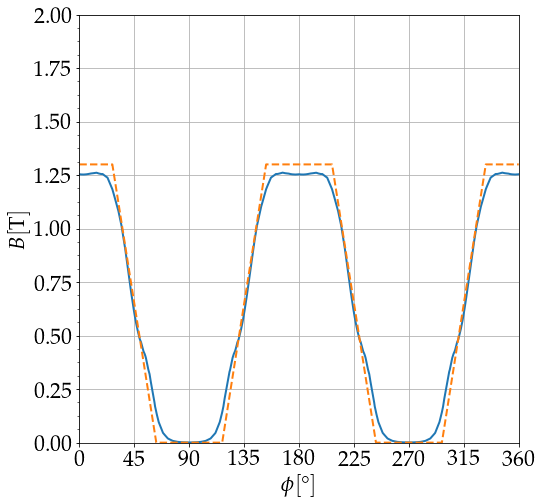

In [140]:



params_optimization_2["R_s"] = 0.255



tmm_g_2, K_2 = optimize_ramp(B_high,field_fraction,params_optimization_2)

print("Value of the objective function:")
print(K_2)
%matplotlib inline

phi_vector_g, B_vector_g = plot_optimized_ramp(B_high,field_fraction)

phi_vector_g = np.deg2rad(phi_vector_g)
B_vector_g_2 = B_vector_g[0:90]
phi_vector_g_2 = phi_vector_g[0:90]
#calcula a energia total nesta área
W = ((R_g*1000)**2 - (R_o*1000)**2)*0.5*trapz(B_vector_g_2**2,phi_vector_g_2)
print("W")
print(W)

So it seems that, based on visual inspection, the optimization procedure is acceptable if $K \le 0.002$.

## Ímã da Joana

In [ ]:
B_HIGH_LIMIT = 1.5
FIELD_FRACTION = 0.3
B_REM = 1.26

In [ ]:
# Fixed parameters

FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "H[m]": 30e-3,
    "N_r[]": 10,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

FIXED_PARAMETERS_LARGE_MAGNET = {"R_i": 0.025,
                "h_fc": 0.025,
                'R_g': 0.185,
                "R_e": 0.7,
                "n_II": 0,
                "n_IV": 5,
                "phi_C_II": 0,
                "phi_S_II": 0,
                "phi_S_IV": 60,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

n_II = FIXED_PARAMETERS_LARGE_MAGNET["n_II"]
n_IV = FIXED_PARAMETERS_LARGE_MAGNET["n_IV"]

n = n_II + n_IV

# expand parameters to include remanence magnitudes for each segment
FIXED_PARAMETERS_LARGE_MAGNET = teslamax.expand_parameters_from_remanence_array(B_REM*np.ones(n), 
                                                                      FIXED_PARAMETERS_LARGE_MAGNET, 
                                                                      "B_rem")

In [ ]:
%%time

B_high = 1.5

params_magnet_large = FIXED_PARAMETERS_LARGE_MAGNET.copy()

params_magnet_large["R_o"] = 153e-3
params_magnet_large["R_s"] = 320e-3

tmm_g_large, K_large = optimize_ramp(B_high,FIELD_FRACTION,params_magnet_large)

print("Value of the objective function:")
print(K_large)

In [ ]:
%matplotlib inline

plot_optimized_ramp(B_high,FIELD_FRACTION)
